_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote , Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat gpt, used for autompletion and debugging.*

# Coding Lab 3

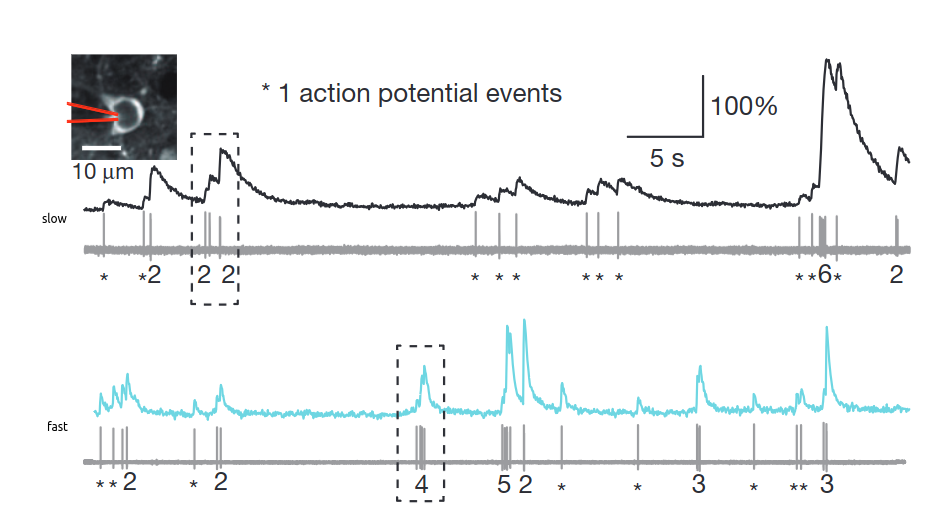

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations
import os

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-10 14:43:58Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.22.2

sklearn: 1.4.2

scipy     : 1.12.0
numpy     : 1.26.4
pandas    : 2.2.1
matplotlib: 3.8.3
seaborn   : 0.13.2

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [4]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# view the calcium data
ogb_calcium.describe()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
count,71986.000000,71986.000000,35993.000000,71985.000000,71986.000000,71986.000000,71986.000000,71985.000000,71986.000000,59717.000000,71986.000000
mean,0.646770,0.651609,0.662335,0.653130,0.671513,0.653020,0.679811,0.658057,0.659958,0.651729,0.653436
std,0.444488,0.420958,0.452687,0.463706,0.614759,0.452244,0.479134,0.640691,0.483874,0.462150,0.431064
min,-0.685101,-0.808990,-0.763746,-0.608734,-0.499646,-0.757015,-1.225060,-0.532283,-0.865865,-0.601771,-0.915395
25%,0.332417,0.351114,0.351401,0.333601,0.274208,0.336880,0.387669,0.242791,0.331718,0.331490,0.346777
50%,0.603039,0.632649,0.620167,0.595368,0.524246,0.605626,0.624212,0.469130,0.592295,0.600702,0.628503
75%,0.915306,0.927438,0.922537,0.910758,0.879348,0.915782,0.912361,0.848345,0.906697,0.913126,0.923177
max,3.134580,2.641432,3.058852,4.287273,4.399176,3.670119,5.232165,4.586872,3.545957,3.708960,2.971287


--> the max value of spikes is 5, not binary!

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

In [5]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------

# Replace the NaN values with 0 in the calcium dataframes (issues with scipy.signal.decimate)
ogb_calcium = ogb_calcium.fillna(0)
gcamp_calcium = gcamp_calcium.fillna(0)

# Replace the NaN values with 0 in the spikes dataframes
ogb_spikes = ogb_spikes.fillna(0)
gcamp_spikes = gcamp_spikes.fillna(0)

# Resample OGB calcium from 100Hz to 25Hz for easier processing using scipy.signal.decimate
ogb_calcium = signal.decimate(ogb_calcium.values, 4, axis=0, zero_phase=True)
# add up the spikes per four entries to get the downsampled spikes
ogb_spikes = ogb_spikes.groupby(ogb_spikes.index // 4).sum()


# control shape after resampling
print(
    f"After resampling: [OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}"
)


# Resample GCaMP data from 100Hz to 25Hz for easier processing using scipy.signal.decimate
gcamp_calcium = signal.decimate(gcamp_calcium.values, 4, axis=0, zero_phase=True)

# add up the spikes per four entries to get the downsampled spikes
gcamp_spikes = gcamp_spikes.groupby(gcamp_spikes.index // 4).sum()
# control shape after resampling
print(
    f"After resampling: [GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}"
)

After resampling: [OGB] calcium: (17997, 11), spikes: (17997, 11)
After resampling: [GCaMP] calcium: (5994, 37), spikes: (5994, 37)


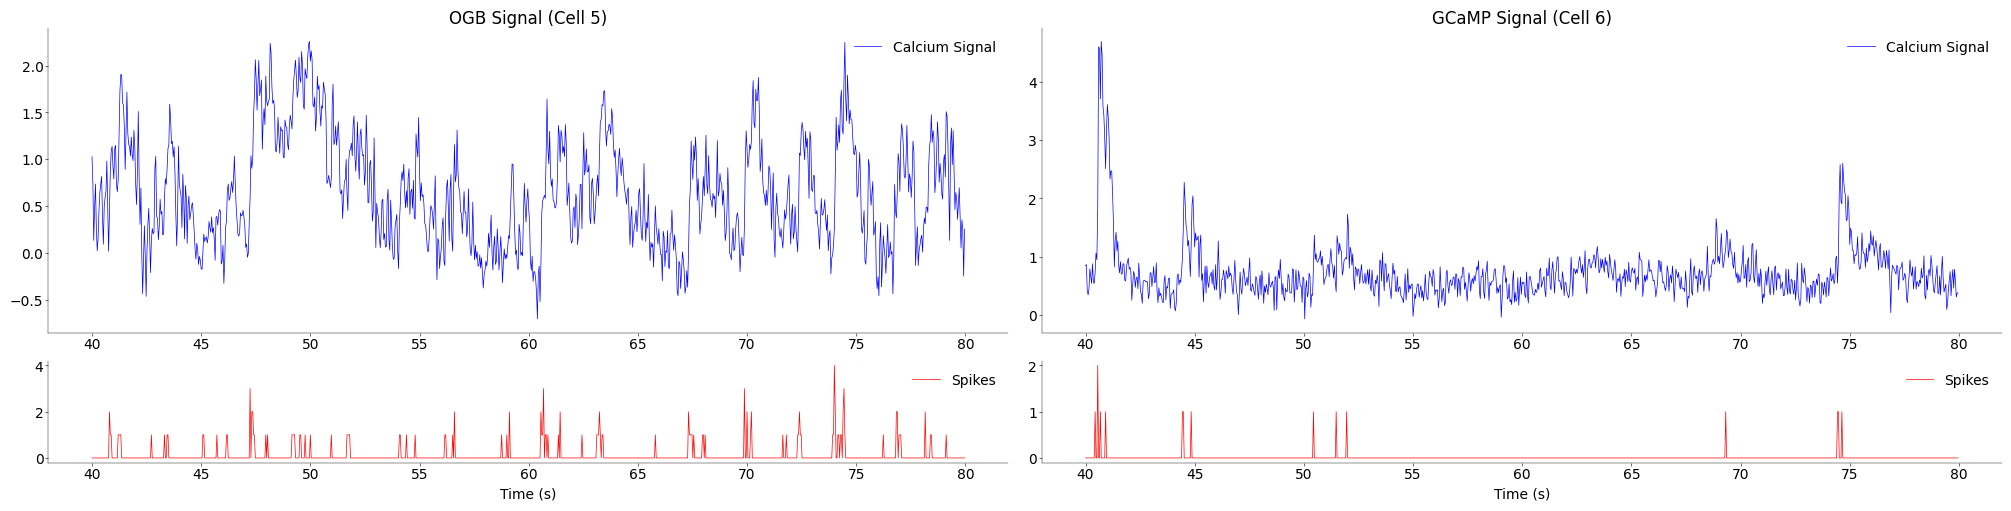

In [6]:
# plot example data
fig, axs = plt.subplots(
    2, 2, figsize=(20, 5), height_ratios=[3, 1], layout="constrained"
)

# chose time window for data
time_idx = [1000, 2000]
time = np.arange(time_idx[0] / 25, time_idx[1] / 25, 0.04)  # 0.04s time step (25Hz)

# use cell 5 from the OGB dataset
ogb_calcium_cell5 = ogb_calcium[time_idx[0] : time_idx[1], 6]

# add a small x offset to the spikes to make them aligned
offset_ogb = 0  # use the value you provided above
ogb_spikes_cell5 = ogb_spikes.iloc[
    time_idx[0] + offset_ogb : time_idx[1] + offset_ogb, 6
]

axs[0, 0].plot(time, ogb_calcium_cell5, color="blue", label="Calcium Signal", lw=0.5)
axs[0, 0].set_title("OGB Signal (Cell 5)")
axs[1, 0].plot(time, ogb_spikes_cell5, color="red", label="Spikes", lw=0.5)


# use cell 6 from the GCaMP dataset
gcamp_calcium_cell6 = gcamp_calcium[time_idx[0] : time_idx[1], 7]

# add a small x offset to the spikes to make them aligned
offset_gcamp = 0  # use the value you provided above
gcamp_spikes_cell6 = gcamp_spikes.iloc[
    time_idx[0] + offset_gcamp : time_idx[1] + offset_gcamp, 7
]

axs[0, 1].plot(time, gcamp_calcium_cell6, color="blue", label="Calcium Signal", lw=0.5)
axs[0, 1].set_title("GCaMP Signal (Cell 6)")
axs[1, 1].plot(time, gcamp_spikes_cell6, color="red", label="Spikes", lw=0.5)

[axs[1, i].set_xlabel("Time (s)") for i in range(2)]
[axs[i, j].legend() for i in range(2) for j in range(2)]
plt.show()

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [7]:
# --------------------------------
# Bonus Task: Smoothering and Filtering (1 pt)
# --------------------------------

# filter the signal with a butterworth filter
butter = signal.butter(3, 7, btype="low", fs=25, output="sos")
# filter the signal with a butterworth filter
ogb_calcium_filt = signal.sosfiltfilt(butter, ogb_calcium, axis=0)
gcamp_calcium_filt = signal.sosfiltfilt(butter, gcamp_calcium, axis=0)

c:\Users\Julius\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Julius\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


difference: 0.11360903041752729
difference: 0.056804515208763784
difference: 0.028402257604381975
difference: 0.014201128802190877
difference: 0.007100564401095355
difference: 0.0035502822005477608
difference: 0.0017751411002737694
difference: 0.0008875705501369957
difference: 0.00044378527506849785
difference: 0.0002218926375341379
difference: 0.00011094631876717997
difference: 5.547315938370101e-05
difference: 2.7736579691739482e-05
difference: 1.3868289845786475e-05
difference: 6.934144922976504e-06
difference: 3.46707246162703e-06
difference: 1.733536230674737e-06
difference: 8.667681152263462e-07
difference: 4.3338405769643984e-07
difference: 2.166920288759755e-07
difference: 1.0834601432696545e-07
difference: 5.417300724674945e-08
difference: 2.7086503762152603e-08
difference: 1.3543251797809575e-08
difference: 6.771625871149212e-09
difference: 3.3858129078190302e-09
difference: 1.6929065926873932e-09
difference: 8.464531853213941e-10
difference: 4.232266204162727e-10
difference:

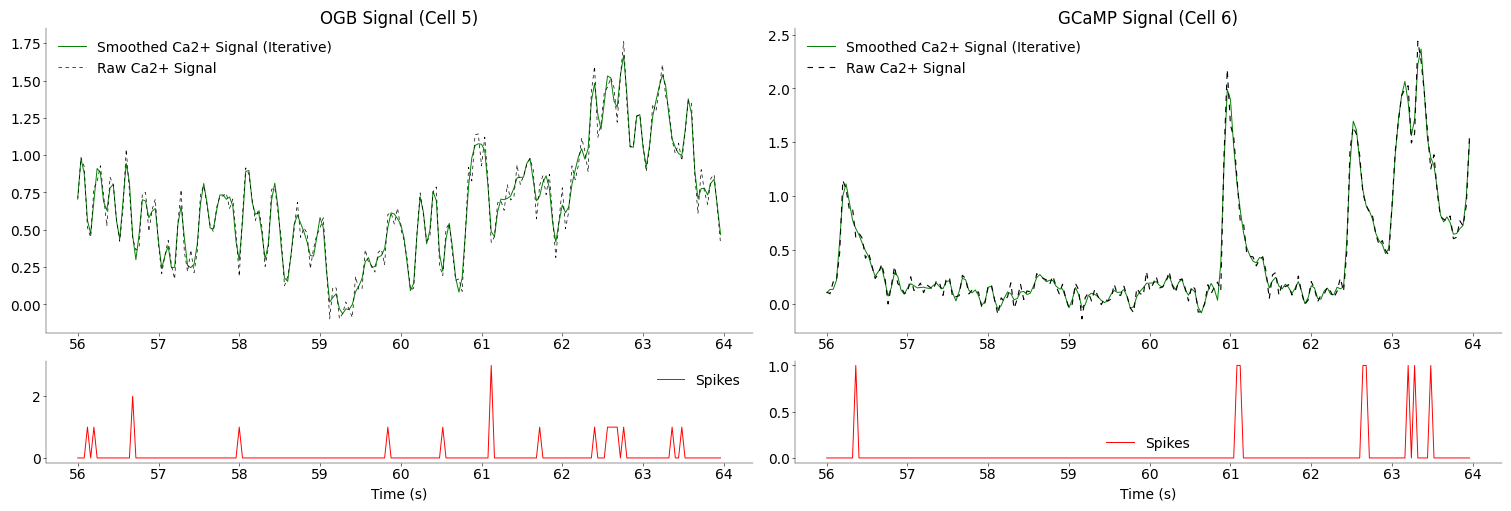

In [ ]:
# smooth by the iterative approach from Yaksi & Fredrich 2006
def yaksi_friedrich_smooth(
    calcium_data: np.ndarray,
    thrnoise: float = 1.0,
    sm_iter: int = 3,
    max_iterations: int = 5000,
) -> np.ndarray:
    """
    Apply the Yaksi & Friedrich (2006) smoothing procedure to calcium imaging data.

    Parameters:
    -----------
    calcium_data : np.ndarray
        Calcium data, shape (time_points, cells).
    thrnoise : float
        Threshold for peak amplitudes to be considered noise.
    sm_iter : int
        Number of local averaging iterations for each smoothing step.
    max_iterations : int
        Maximum number of iterations for the whole procedure.

    Returns:
    --------
    np.ndarray
        Smoothed calcium data.
    """
    # Create a copy of the data to avoid modifying the original
    smoothed_data_all_cells = np.copy(calcium_data)

    # Process each cell separately
    for cell in range(calcium_data.shape[1]):
        # Get the calcium trace for the current cell
        trace = smoothed_data_all_cells[:, cell].copy()

        iteration = 0
        while iteration < max_iterations:
            # Find all peaks
            peak_indices, _ = signal.find_peaks(trace, height=0, distance=1)

            peaks = trace[peak_indices].copy()

            # Check if there are enough extrema to continue
            if len(peaks) < 2:
                print(
                    f"Not enough peaks found in cell {cell} at iteration {iteration}. Stopping."
                )
                break  # Not enough extrema to continue

            # calculate the differnce between the peaks as current peak and preceeding peak
            amplitudes = np.diff(peaks)

            # Find the smallest amplitude
            min_amplitude = np.min(amplitudes)

            # break if the smallest amplitude is above the threshold
            if min_amplitude > thrnoise:
                print(
                    f"All peaks below threshold in cell {cell} at iteration {iteration}. Stopping."
                )
                break  # All peaks below threshold

            # Find the peak with smallest amplitude
            min_amp_idx = np.argmin(amplitudes)

            # Find peaks adjacent to pmin
            # for the most left peak
            if min_amp_idx == 0:
                seg_peak_idxs = [
                    peak_indices[min_amp_idx],
                    peak_indices[min_amp_idx + 1],
                ]
            # for the most right peak
            elif min_amp_idx == len(peaks):
                seg_peak_idxs = [
                    peak_indices[min_amp_idx - 1],
                    peak_indices[min_amp_idx],
                ]
            else:
                seg_peak_idxs = [
                    peak_indices[min_amp_idx - 1],
                    peak_indices[min_amp_idx],
                    peak_indices[min_amp_idx + 1],
                ]

            # Create a copy of the segment to smooth (- 1 and + 2 to include all neighbours of all peaks)
            segment = trace[seg_peak_idxs[0] - 1 : seg_peak_idxs[-1] + 2].copy()
            original_segment = segment.copy()
            # Apply smoothing multiple times
            for _ in range(sm_iter):

                # create a copy of the segment to smooth
                new_segment = segment.copy()

                # first peak
                new_segment[1] = np.mean(segment[0:2])

                # last peak
                new_segment[-1] = np.mean(segment[-2:])

                # middle peak
                # get relative peak position
                rel_min_idx = (
                    seg_peak_idxs.index(peak_indices[min_amp_idx])
                    - seg_peak_idxs[0]
                    + 1
                )

                new_segment[rel_min_idx - 1 : rel_min_idx + 2] = np.mean(
                    segment[rel_min_idx - 1 : rel_min_idx + 2]
                )
                
                # replace old segment with the new one
                segment = new_segment

            # Check if smoothing made any change
            if np.array_equal(segment, original_segment):
                print(
                    f"No change in smoothed segment for cell {cell} at iteration {iteration}. Stopping."
                )
                break

            # Replace the segment in the trace
            trace[seg_peak_idxs[0] - 1 : seg_peak_idxs[-1] + 2] = segment
            iteration += 1

        # Update the smoothed data for this cell
        smoothed_data_all_cells[:, cell] = trace

    return smoothed_data_all_cells


# apply the iterative smoother
ogb_calcium_smooth_iterative = yaksi_friedrich_smooth(
    ogb_calcium_filt, thrnoise=1, sm_iter=5, max_iterations=5000
)
gcamp_calcium_smooth_iterative = yaksi_friedrich_smooth(
    gcamp_calcium_filt, thrnoise=1, sm_iter=5, max_iterations=5000
)

# create new time index for the smoothed data (smaller time window to see the effect of smoothing)
time_idx_smooth = [1400, 1600]

time_smooth = np.arange(
    time_idx_smooth[0] / 25, time_idx_smooth[1] / 25, 0.04
)  # 0.04s time step (25Hz)

# plot example data
fig, axs = plt.subplots(
    2, 2, figsize=(15, 5), height_ratios=[3, 1], layout="constrained"
)

ogb_calcium_cell5_smooth_iterative = ogb_calcium_smooth_iterative[
    time_idx_smooth[0] : time_idx_smooth[1], 5
]

# adapt the old cells to the new time window
ogb_calcium_cell5 = ogb_calcium[time_idx_smooth[0] : time_idx_smooth[1], 5]

# add a small x offset to the spikes to make them aligned
offset_ogb = -8  # use the value you provided above
ogb_spikes_cell5 = ogb_spikes.iloc[
    time_idx_smooth[0] + offset_ogb : time_idx_smooth[1] + offset_ogb, 5
]

axs[0, 0].plot(
    time_smooth,
    ogb_calcium_cell5_smooth_iterative,
    color="green",
    label="Smoothed Ca2+ Signal (Iterative)",
    lw=0.7,
)
# add the old plot for comparison as dash lines
axs[0, 0].plot(
    time_smooth,
    ogb_calcium_cell5,
    "k--",
    dashes=[5, 5],
    lw=0.5,
    label="Raw Ca2+ Signal",
)

axs[0, 0].set_title("OGB Signal (Cell 5)")
axs[1, 0].plot(time_smooth, ogb_spikes_cell5, color="red", label="Spikes", lw=0.7)

# use cell 6 from the GCaMP dataset

gcamp_calcium_cell6 = gcamp_calcium[time_idx_smooth[0] : time_idx_smooth[1], 6]

# adapt the old cells to the new time window
gcamp_calcium_cell6_iterative = gcamp_calcium_smooth_iterative[
    time_idx_smooth[0] : time_idx_smooth[1], 6
]

# add a small x offset to the spikes to make them aligned
offset_gcamp = -5  # use the value you provided above
gcamp_spikes_cell6 = gcamp_spikes.iloc[
    time_idx_smooth[0] + offset_gcamp : time_idx_smooth[1] + offset_gcamp, 6
]

axs[0, 1].plot(
    time_smooth,
    gcamp_calcium_cell6_iterative,
    color="green",
    label="Smoothed Ca2+ Signal (Iterative)",
    lw=0.7,
)

axs[0, 1].plot(
    time_smooth,
    gcamp_calcium_cell6,
    "k--",
    lw=0.8,
    dashes=[5, 5],
    label="Raw Ca2+ Signal",
)
axs[0, 1].set_title("GCaMP Signal (Cell 6)")
axs[1, 1].plot(time_smooth, gcamp_spikes_cell6, color="red", label="Spikes", lw=0.7)


[axs[1, i].set_xlabel("Time (s)") for i in range(2)]
[axs[i, j].legend() for i in range(2) for j in range(2)]

# set a title for the whole figure

plt.show()

Ideally, application of the low-pass filter helps to remove high-frequency noise (especially in the OGB dataset). In this sense the smoothing procedure is intended to increase local signal-to-noise ratio. However, as for the time window seen in the figure above, the difference between the raw data and smoothed calcium signal is marginal, especially for the GCamp6 dataset where the data seems to be already stable and peaks in fluorescence coincide well with the spikes. It also becomes appareant that the iterative algorithm has difficulties smoothing the OGB dataset due to it being a lot noiser - spikes and "valleys" are a lot sharper. In comparison, the Gaussian filter is more robust and smooths the data better yet it does not keep peak geometry as well.

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [ ]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    return sp_hat

In [ ]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")


### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

In [ ]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamp Cell


## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [ ]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [ ]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [ ]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
